<a href="https://colab.research.google.com/github/tkys/multilingual-e5_onnx/blob/main/multilingual_e5_onnxruntime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! cat  /proc/cpuinfo  | grep name

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz


In [2]:
! git clone https://huggingface.co/intfloat/multilingual-e5-small

Cloning into 'multilingual-e5-small'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 43 (delta 10), reused 0 (delta 0), pack-reused 14
Unpacking objects: 100% (43/43), 52.34 KiB | 645.00 KiB/s, done.
Filtering content: 100% (7/7), 1.35 GiB | 6.22 MiB/s, done.


In [3]:
! ls -alh ./multilingual-e5-small/onnx

total 470M
drwxr-xr-x 2 root root 4.0K Feb 16 06:06 .
drwxr-xr-x 5 root root 4.0K Feb 16 06:03 ..
-rw-r--r-- 1 root root  653 Feb 16 06:02 config.json
-rw-r--r-- 1 root root 449M Feb 16 06:06 model.onnx
-rw-r--r-- 1 root root 4.9M Feb 16 06:02 sentencepiece.bpe.model
-rw-r--r-- 1 root root  167 Feb 16 06:02 special_tokens_map.json
-rw-r--r-- 1 root root  443 Feb 16 06:02 tokenizer_config.json
-rw-r--r-- 1 root root  17M Feb 16 06:02 tokenizer.json


In [4]:
! pip install onnx onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 13.4 MB/s eta 0:00:00


In [5]:
##　onnxモデルがどんなIN/OUTか確認するだけ

import onnx

# ONNXモデルのロード
model_path = "/content/multilingual-e5-small/onnx/model.onnx"
model = onnx.load(model_path)


# モデルの入力と出力の情報

print("\n## モデルの入力:")
for input in model.graph.input:
    print(f"{input.name}, {input.type}")

print("\n##モデルの出力:")
for output in model.graph.output:
    print(f"{output.name}, {output.type}")


## モデルの入力:
input_ids, tensor_type {
  elem_type: 7
  shape {
    dim {
      dim_param: "batch_size"
    }
    dim {
      dim_param: "sequence_length"
    }
  }
}

attention_mask, tensor_type {
  elem_type: 7
  shape {
    dim {
      dim_param: "batch_size"
    }
    dim {
      dim_param: "sequence_length"
    }
  }
}

token_type_ids, tensor_type {
  elem_type: 7
  shape {
    dim {
      dim_param: "batch_size"
    }
    dim {
      dim_param: "sequence_length"
    }
  }
}


##モデルの出力:
last_hidden_state, tensor_type {
  elem_type: 1
  shape {
    dim {
      dim_param: "batch_size"
    }
    dim {
      dim_param: "sequence_length"
    }
    dim {
      dim_value: 384
    }
  }
}



In [6]:
import onnx
import onnxruntime as ort
from transformers import AutoTokenizer


In [7]:
import numpy as np

In [8]:

# 1. トークナイザー
tokenizer = AutoTokenizer.from_pretrained("/content/multilingual-e5-small/onnx") #dirパスごと指定

# 2. ONNXモデルパス
onnx_model_path = "/content/multilingual-e5-small/onnx/model.onnx"

# 3. runtime session 作成
session = ort.InferenceSession(onnx_model_path)


In [9]:
# onnxモデルの入力ノードdictの確認 # 👆で既に確認したが
input_names = [input.name for input in session.get_inputs()]

print(" onnxモデルの入力ノード:", input_names)

 onnxモデルの入力ノード: ['input_ids', 'attention_mask', 'token_type_ids']


In [10]:
# 入力テキスト
text = "ディスプレイがつかない。 "

# tokenize
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)


In [11]:
#見てみる
inputs

{'input_ids': tensor([[     0,      6,  39601,   3385, 125954,    281, 226591,     30,      6,
              2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [12]:

#  onnxモデルへの入力ノードに沿ったデータ作成する
input_feed = {
    'input_ids': inputs['input_ids'].numpy(),
    'attention_mask': inputs['attention_mask'].numpy(),
}

# input_feed[`token_type_ids`]も必要だがもって無いので、手動で追加する（全て0の配列を生成）
input_feed['token_type_ids'] = np.zeros_like(inputs['input_ids'].numpy())



In [13]:
#見てみる
input_feed

{'input_ids': array([[     0,      6,  39601,   3385, 125954,    281, 226591,     30,
              6,      2]]),
 'attention_mask': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'token_type_ids': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [14]:

# モデルに入力
outputs = session.run(None, input_feed) # session.run(output_name,input_feed)　 output_nameはNoneでもいいが、👆で確認したモデルの出力ノード名["last_hidden_state"]を明示指定してもOK

# 出力ベクトル取得
encoded_vector = outputs[0]

#
print(encoded_vector)
print(encoded_vector.shape)

[[[ 0.21865204 -0.04455148 -0.18693127 ...  0.10748932  0.08861979
    0.04202938]
  [ 0.23228452 -0.0442718  -0.0215985  ...  0.18467855  0.30522713
    0.2824254 ]
  [ 0.21584222 -0.07112919 -0.1089538  ...  0.01026974  0.04115607
    0.15442488]
  ...
  [ 0.25109327 -0.03354806 -0.152942   ...  0.24721311  0.31745362
    0.29802948]
  [ 0.2451328  -0.00767547 -0.01601937 ...  0.15090165  0.26564133
    0.25788653]
  [ 0.2186499  -0.04454774 -0.18693393 ...  0.1074903   0.08862248
    0.04202624]]]
(1, 10, 384)


In [15]:
session.run(None, input_feed)

[array([[[ 0.21865204, -0.04455148, -0.18693127, ...,  0.10748932,
           0.08861979,  0.04202938],
         [ 0.23228452, -0.0442718 , -0.0215985 , ...,  0.18467855,
           0.30522713,  0.2824254 ],
         [ 0.21584222, -0.07112919, -0.1089538 , ...,  0.01026974,
           0.04115607,  0.15442488],
         ...,
         [ 0.25109327, -0.03354806, -0.152942  , ...,  0.24721311,
           0.31745362,  0.29802948],
         [ 0.2451328 , -0.00767547, -0.01601937, ...,  0.15090165,
           0.26564133,  0.25788653],
         [ 0.2186499 , -0.04454774, -0.18693393, ...,  0.1074903 ,
           0.08862248,  0.04202624]]], dtype=float32)]

In [16]:
#関数化
def emcode_onnx(session,input_text:str):
  inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)

  # 入力辞書の準備
  input_feed = {
      'input_ids': inputs['input_ids'].numpy(),
      'attention_mask': inputs['attention_mask'].numpy(),
  }

  # input_feed[`token_type_ids`]が必要なので、手動で追加（全て0の配列を生成）
  input_feed['token_type_ids'] = np.zeros_like(inputs['input_ids'].numpy())


  # モデルへ入力
  outputs = session.run(None, input_feed)

  # 出力ベクトル取得
  encoded_vector = outputs[0]

  #print(encoded_vector)

  return encoded_vector



In [17]:
text = "Start using open-source software in minutes"

print(emcode_onnx(session,text))
print(emcode_onnx(session,text).shape)

[[[ 0.17999783 -0.04057322 -0.19378749 ...  0.23418048  0.03804934
    0.05502447]
  [ 0.18267345 -0.1542196   0.21307006 ...  0.48656797  0.16380218
    0.2404509 ]
  [ 0.00050503 -0.27400565  0.04302146 ...  0.3787657  -0.13050175
    0.21006621]
  ...
  [ 0.07364069 -0.04141909 -0.02288921 ...  0.43417826 -0.12035015
    0.20888083]
  [-0.08164199  0.02301908 -0.23771703 ...  0.35335115 -0.02888722
    0.17335638]
  [ 0.17999843 -0.04056928 -0.1937894  ...  0.23418029  0.03805151
    0.05502164]]]
(1, 10, 384)


In [18]:
#テキスト類似度関数

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# コサイン類似度
def cos_sim(encoded_vector1,encoded_vector2):

  # テキストtokenベクトルの平均を計算
  mean_vector1 = np.mean(encoded_vector1, axis=1)
  mean_vector2 = np.mean(encoded_vector2, axis=1)

  # コサイン類似度
  similarity = cosine_similarity(mean_vector1, mean_vector2)

  return similarity


In [19]:
import time

In [57]:
query_text = "能登半島地震"

news_list = """
日本のアジア杯敗退に“隠せぬ本音”を吐露 ブライトン指揮官が三笘薫の重要性を語る「日本人を愛しているが、私は嬉しい」（CoCoKARAnext）昨日JBpress
能動的サイバー防御を詳解：日本はいつまでサイバー攻撃に丸腰でいるのか 日本が対応できない法的問題、技術的問題と各国の情勢(1/12)4 日経ビジネスオンライン
曲がる次世代太陽電池 日本発の有望技術に中国の足音再び5
ビジネス米テスラ株が下落、独ＳＡＰの車両調達打ち切り報道などで1
円は対ドルで148円台後半に下落、ＩＳＭ指数を受けた米金利一段高で3 日経平均株価
歌手のテイラー・スウィフトさん 米グラミー賞で史上最多、4度目の最優秀アルバム賞に(2024年2月5日)14
チャールズ英国王「がん」治療開始、英王室は詳しい病状明らかにせず…入院もせず事務的執務を継続6
ＮＨＫ朝ドラ「ブギウギ」 スズ子役の趣里、トミ役の小雪と念願の〝仲良し写真〟…視聴者「愛助も見たかったでしょうね」22 物理学東京大学
音波を閉じ込めてスピン波との強結合を室温で実証 －スピン波-音波を活用した新しいデバイスへ道－ | 物性研究所5
日前重力っていったい何？ すべての物に力が働く、空間のひずみ：朝日新聞デジタル3 日前日本経済新聞
高エネルギー加速器研究機構、国内最大の加速器再始動 「反物質」の謎を探索4 日前
発電側課金導入で４月から規制料金変更／北海道・北陸・四国の３社が申請4
東電管内で１．３万軒停電＝東京など６都県、原因調査中10
石川 能登町の水道復旧支援 長浜水道企業団の職員らが出発｜NHK 滋賀県のニュース22
インターネット セキュリティ外務省公電情報が漏洩 中国からサイバー攻撃 閉域システムに侵入21
中国のネット監視・検閲「グレートファイアウォール」を個人で再現 オープンソース「OpenGFW」公開中2 Yahoo!ニュース
中国支援のサイバー攻撃用ネットワーク解体、米当局発表（ＡＦＰ＝時事）5 日前ニュース提供元
ハマス戦闘員半数以上死傷か
「完全勝利」まで戦闘継続＝イスラエル首相国王の決定で公表
英国王、がんと診断　王室は種類明かさず2日の空爆前に
米、イラクに事前通告せず ＝国務省
ブタの腎臓を胎児に移植、透析までの「橋渡し」に…国内初「異種移植」を慈恵医大など計画音楽
テイラー・スウィフトさん「人生最高の瞬間」、史上最多４回目のグラミー最優秀アルバム賞国際
ゼレンスキー氏、ザルジニー総司令官の解任検討初めて認める…「リセットが必要だ」
放置された築200年の古民家は多くの支えで再生した　カフェ「かやぶき日記」新たな日々愛知
エスカレーター歩くと「条例違反です」ＡＩ声掛け　名古屋市営地下鉄で実証実験岐阜
「柿畑は財産だ」富有柿の定番手土産を開発中　瑞穂の農家の第１弾「最中アイス」
プーチン　ウクライナ　戦争　ロシア軍　降伏
「主導権は完全に露軍に移った」プーチン氏、ウクライナに降伏要求中国　サッカー　腐敗　代表監督　弱い
中国サッカーが弱い理由は…代表監督まで腐敗まみれ前橋市長選　自民現職　敗北　前橋ショック　小川晶
王国で自民現職敗れる〝前橋ショック〟「政治不信が…」「政権交代起きてもおかしくない」
"""

#target_list = news_list.split("\n")

n = 512 # max_token 日本語だし1文字1tokenでよい
target_list = [news_list[i:i+n] for i in range(0,len(news_list), n)]

import random

random.shuffle(target_list)



encode_time=[]
encode_token_len=[]
for target in target_list:

  st=time.time()
  encode_vec = emcode_onnx(session,target)
  encode_time.append(time.time()-st)

  query_vec  = emcode_onnx(session,query_text)

  encode_token_len.append(encode_vec.shape[1])

  print(f"cos_sim {format(cos_sim(encode_vec,query_vec)[0][0],'.3f')}\t{query_text} : {target}")


print(f"\n")
print(f"encode_time_sum:{sum(encode_time)}")
print(f"encode_token_len_sum:{sum(encode_token_len)}")
print(f"encode speed (token/sec):{sum(encode_token_len)/sum(encode_time)}")


cos_sim 0.826	能登半島地震 : ルバム賞国際
ゼレンスキー氏、ザルジニー総司令官の解任検討初めて認める…「リセットが必要だ」
放置された築200年の古民家は多くの支えで再生した　カフェ「かやぶき日記」新たな日々愛知
エスカレーター歩くと「条例違反です」ＡＩ声掛け　名古屋市営地下鉄で実証実験岐阜
「柿畑は財産だ」富有柿の定番手土産を開発中　瑞穂の農家の第１弾「最中アイス」
プーチン　ウクライナ　戦争　ロシア軍　降伏
「主導権は完全に露軍に移った」プーチン氏、ウクライナに降伏要求中国　サッカー　腐敗　代表監督　弱い
中国サッカーが弱い理由は…代表監督まで腐敗まみれ前橋市長選　自民現職　敗北　前橋ショック　小川晶
王国で自民現職敗れる〝前橋ショック〟「政治不信が…」「政権交代起きてもおかしくない」

cos_sim 0.848	能登半島地震 : 物に力が働く、空間のひずみ：朝日新聞デジタル3 日前日本経済新聞
高エネルギー加速器研究機構、国内最大の加速器再始動 「反物質」の謎を探索4 日前
発電側課金導入で４月から規制料金変更／北海道・北陸・四国の３社が申請4
東電管内で１．３万軒停電＝東京など６都県、原因調査中10
石川 能登町の水道復旧支援 長浜水道企業団の職員らが出発｜NHK 滋賀県のニュース22
インターネット セキュリティ外務省公電情報が漏洩 中国からサイバー攻撃 閉域システムに侵入21
中国のネット監視・検閲「グレートファイアウォール」を個人で再現 オープンソース「OpenGFW」公開中2 Yahoo!ニュース
中国支援のサイバー攻撃用ネットワーク解体、米当局発表（ＡＦＰ＝時事）5 日前ニュース提供元
ハマス戦闘員半数以上死傷か
「完全勝利」まで戦闘継続＝イスラエル首相国王の決定で公表
英国王、がんと診断　王室は種類明かさず2日の空爆前に
米、イラクに事前通告せず ＝国務省
ブタの腎臓を胎児に移植、透析までの「橋渡し」に…国内初「異種移植」を慈恵医大など計画音楽
テイラー・スウィフトさん「人生最高の瞬間」、史上最多４回目のグラミー最優秀ア
cos_sim 0.834	能登半島地震 : 
日本のアジア杯敗退に“隠せぬ本音”を吐露 ブライトン指揮官が三笘薫の重要性を語る「日本人を愛しているが、私は嬉しい」（CoCoKARAnext）昨日JBpress

In [21]:
query_vec.shape[1]

8

In [22]:
! pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 2.6 MB/s eta 0:00:00


In [23]:
##計測

from sentence_transformers import SentenceTransformer

model_name = "intfloat/multilingual-e5-small"

# モデルのロード
model = SentenceTransformer(model_name)



random.shuffle(target_list)

st = time.time()
# 例えば、以下のクエリベクトルを使用して検索を実行する
query_vector = model.encode(target_list)

encode_time_sum = time.time()-st

print(f"\n## Benchmark ##\n")
print(f"encode_time.sum:{encode_time_sum}")
print(f"encode_token_len_sum:{sum(encode_token_len)}")
print(f"encode speed (token/sec):{sum(encode_token_len)/encode_time_sum}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/160k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]


## Benchmark ##

encode_time.sum:9.793078660964966
encode_token_len_sum:3841
encode speed (token/sec):392.2157814692285


In [36]:
def text_shuf_list(source_text:str):
  sampled_str_list = random.sample(source_text, len(source_text))
  sampled_str = ''.join(sampled_str_list)

  n = 512 # max_token 日本語だし1文字1tokenでよい
  target_list = [sampled_str[i:i+n] for i in range(0,len(sampled_str), n)]


  return target_list

In [61]:
print(f"\n## Benchmark ##\n")

onnx_time =[]
onnx_token_sum = []

norm_time =[]
norm_token_sum = []

traial_num = 10

for i in range(traial_num):
  ## onnx

  target_list=  text_shuf_list(news_list)

  encode_time=[]
  encode_token_len=[]
  for target in target_list:

    st=time.time()
    encode_vec = emcode_onnx(session,target)
    encode_time.append(time.time()-st)

    query_vec  = emcode_onnx(session,query_text)

    encode_token_len.append(encode_vec.shape[1])

    #print(f"cos_sim {format(cos_sim(encode_vec,query_vec)[0][0],'.3f')}\t{query_text} : {target}")


  #print(f"\n# ONNX ")
  #print(f"encode_time_sum:\t{round(sum(encode_time),4)}")
  #print(f"encode_token_len_sum:\t{sum(encode_token_len)}")
  #print(f"encode_speed:\t{round(sum(encode_token_len)/sum(encode_time),2)}  (token/sec)")

  onnx_time.append(round(sum(encode_time),4))
  onnx_token_sum.append(sum(encode_token_len))


  ## normal

  target_list=  text_shuf_list(news_list)

  st = time.time()
  # 例えば、以下のクエリベクトルを使用して検索を実行する
  query_vector = model.encode(target_list)

  encode_time_sum = time.time()-st

  #print(f"\n# NORMAL")
  #print(f"encode_time.sum:\t{round(encode_time_sum,4)}")
  #print(f"encode_token_len_sum:\t{sum(encode_token_len)}")
  #print(f"encode_speed:\t{round(sum(encode_token_len)/encode_time_sum,2)}  (token/sec)")

  norm_time.append(round(encode_time_sum,4))
  norm_token_sum.append(sum(encode_token_len))

  print(f"Trail:{i} Done")


print("\n\n## Result ##\n")

print(f"Trail_Count:{traial_num} ")

print(f"onnx_time_total\t{sum(onnx_time)}")
print(f"onnx_token_total\t{sum(onnx_token_sum)}")

onnx_speed= round(sum(onnx_token_sum)/sum(onnx_time))
print(f"onnx_speed\t{onnx_speed} token/sec")

print("\n")

print(f"norm_time_total\t{sum(norm_time)}")
print(f"norm_token_total\t{sum(norm_token_sum)}")
norm_speed = round(sum(norm_token_sum)/sum(norm_time))
print(f"norm_speed\t{norm_speed} token/sec")



## Benchmark ##

Trail:0 Done
Trail:1 Done
Trail:2 Done
Trail:3 Done
Trail:4 Done
Trail:5 Done
Trail:6 Done
Trail:7 Done
Trail:8 Done
Trail:9 Done


## Result ##

Trail_Count:10 
onnx_time_total	14.439099999999998
onnx_token_total	13279
onnx_speed	920 token/sec


norm_time_total	28.244899999999998
norm_token_total	13279
norm_speed	470 token/sec


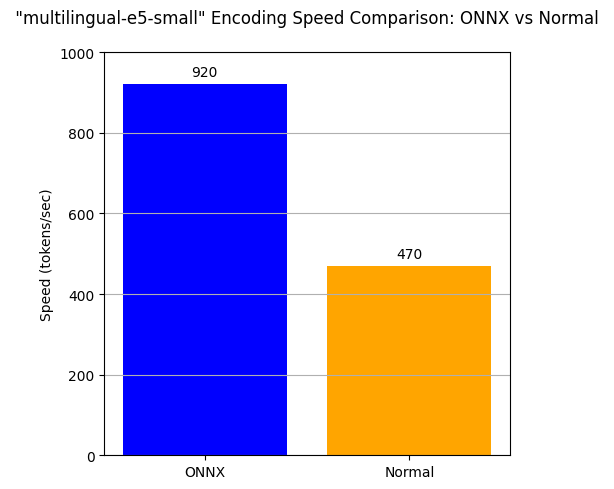

In [74]:
import matplotlib.pyplot as plt

# Given data from the benchmark script
traial_num = 10

# Plotting
labels = ['ONNX', 'Normal']
speeds = [onnx_speed, norm_speed]

plt.figure(figsize=(5, 5))
plt.bar(labels, speeds, color=['blue', 'orange'])
plt.ylabel('Speed (tokens/sec)')
plt.title(' "multilingual-e5-small" Encoding Speed Comparison: ONNX vs Normal \n')
plt.xticks(labels)
plt.yticks(range(0, max(speeds) + 200, 200))
plt.grid(axis='y')

for i, speed in enumerate(speeds):
    plt.text(i, speed + 20, f'{speed}', ha='center')

plt.tight_layout()
plt.show()
